# Jonathan Halverson
# Friday, April 15, 2016
# Ensembles and majority vote

Consider applying different classifiers to the same problem and then making predictions by majority vote (plurality) or some related scheme. If the classifiers are independent and they have an error likelihood of $\epsilon$ then the error rate of the ensemble is less $\epsilon$. For instance consider 11 classifiers each with an error probability of 0.25 then the error probability of the ensemble is

In [1]:
from scipy.stats import binom
1.0 - binom.cdf(p=0.25, k=5, n=11)

0.034327507019042969

The above is equivalent to P(k=6) + P(k=7) + ... + P(k=11) which is the probability of the ensemble to be wrong. When k=5, the number of correct predictions by the 11 classifiers is 6, which by majority gives the correct answer. So the probability of getting the right answer is 0.966.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

Below plot the error rate of the ensemble as a function of the error rate of individual classifiers:

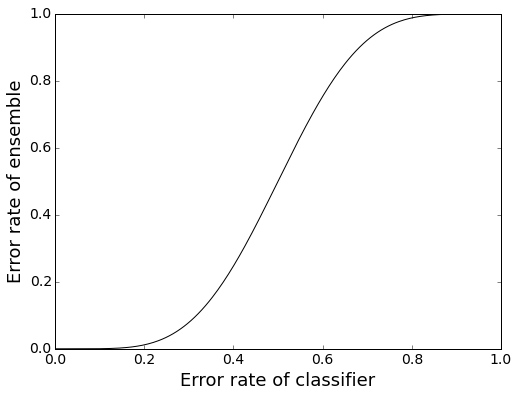

In [3]:
x = np.linspace(0, 1, num=250)
y = [1.0 - binom.cdf(p=p, k=5, n=11) for p in x]
plt.plot(x, y, 'k-')
plt.xlabel('Error rate of classifier')
plt.ylabel('Error rate of ensemble')

The eror rate of the ensemble is always less than that of the individual classifier up to 0.5 which corresponds to random guessing.

### Load data

Next, we load the Wisconsin breat cancer data sets. M is malignant and B is benign. The remaining numerical values are properties taken from an image which characterize the sample.

In [4]:
df = pd.read_csv('wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
X = df.iloc[:, 2:].values
y = df.iloc[:, 1].replace({'M':0, 'B':1}).values

from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Let's standardize the data so that it may be used by a variety of models:

In [6]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Aside with PCA

Because there are many features let's try PCA on the full data set with two principal components:

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

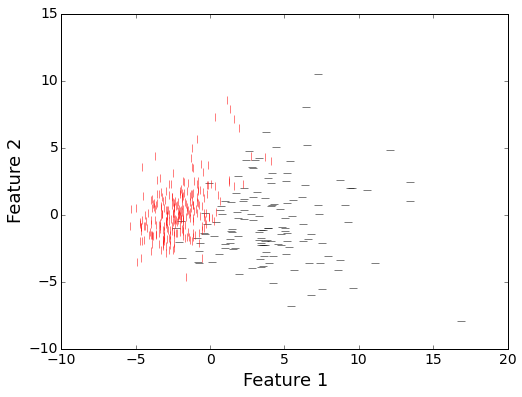

In [8]:
plt.plot(X_train_pca[y_train == 0, 0], X_train_pca[y_train == 0, 1], 'k_')
plt.plot(X_train_pca[y_train == 1, 0], X_train_pca[y_train == 1, 1], 'r|')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

The data are not perfectly linearly separable but we get a sense of the accuracy we expect from the ensemble.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_train_pca, y_train)
accuracy_score(tree.predict(X_test_pca), y_test)

0.88888888888888884

## Optimize individual models

In [10]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

param_grid = dict(C=np.logspace(-3, 3, num=25, base=10), penalty=['l1', 'l2'])
lr = LogisticRegression()
grid1 = GridSearchCV(lr, param_grid, cv=10, scoring='accuracy')
grid1.fit(X_train_std, y_train)
print grid1.best_score_, grid1.best_params_, accuracy_score(grid1.best_estimator_.predict(X_test_std), y_test)

0.977386934673 {'penalty': 'l2', 'C': 0.17782794100389229} 0.988304093567


### SVM

In [12]:
from sklearn.svm import SVC

param_grid = dict(C=np.logspace(-3, 3, num=25, base=10), gamma=np.logspace(-4, 4, num=25, base=10))
svm = SVC(kernel='linear')
grid2 = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
grid2.fit(X_train_std, y_train)
print grid2.best_score_, grid2.best_params_, accuracy_score(grid2.best_estimator_.predict(X_test_std), y_test)

0.974874371859 {'C': 0.031622776601683791, 'gamma': 0.0001} 0.970760233918


### K-Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = dict(n_neighbors=range(1, 26), metric=['manhattan', 'chebyshev', 'euclidean'])
knn = KNeighborsClassifier()
grid3 = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid3.fit(X_train_std, y_train)
print grid3.best_score_, grid3.best_params_, accuracy_score(grid3.best_estimator_.predict(X_test_std), y_test)

0.969849246231 {'n_neighbors': 8, 'metric': 'euclidean'} 0.988304093567


### Random forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, criterion='entropy')
rf.fit(X_train_std, y_train)
print accuracy_score(rf.predict(X_test_std), y_test)

0.959064327485


### Ensemble

In [15]:
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[('lr', grid1.best_estimator_), 
                                    ('svm', grid2.best_estimator_), 
                                    ('knn', grid3.best_estimator_),
                                    ('rf', rf)], voting='hard')
eclf = eclf.fit(X_train_std, y_train)
print accuracy_score(eclf.predict(X_test_std), y_test)

0.988304093567


After running the notebook many times where the train-test split is different, we find that the ensemble classifier is only a slight improvement over the best individual classifier which is typically logistic regression.